In [1]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt 
import re
import matplotlib.patches as patches
from matplotlib.path import Path
from matplotlib import cm

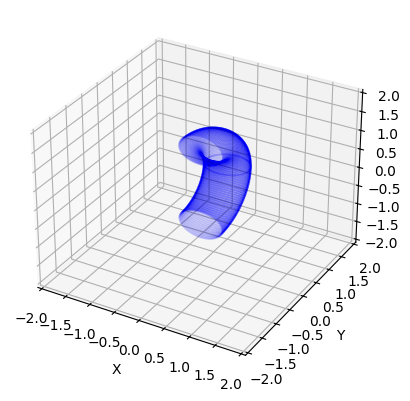

In [2]:
path = '../velocity_results/alpha04_2D_'


geometry_2D = np.load(path + 'geometry.npy')

x_core_2d, y_core_2d, _, x_ring_2d, y_ring_2d = geometry_2D.T

theta = np.linspace(0, 2*np.pi, 181)
Theta = np.repeat(theta[np.newaxis, :], x_core_2d.size, axis=0)
Z_core_2d = y_core_2d[:, np.newaxis] * np.sin(Theta)
Y_core_2d = y_core_2d[:, np.newaxis] * np.cos(Theta)
X_core_2d = np.repeat(x_core_2d[:, np.newaxis], len(theta), axis=1)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
k_theta = len(theta) // 4
cross_section_x = np.concatenate((X_core_2d[:, -k_theta:], X_core_2d[:, :k_theta]))
cross_section_y = np.concatenate((Y_core_2d[:, -k_theta:], Y_core_2d[:, :k_theta]))
cross_section_z = np.concatenate((Z_core_2d[:, -k_theta:], Z_core_2d[:, :k_theta]))

ax.scatter(cross_section_x, cross_section_y, cross_section_z, c='b', s=0.1, alpha=0.05)
# ax.scatter(X_core_2d, Y_core_2d, Z_core_2d, c='r', s=1)
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_zlim(-2, 2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

def find_inside_points(data):
    x_2d = data[:, 1]
    # y_2d = sqrt(y_3d^2 + z_3d^2)
    y_2d = np.sqrt(data[:, 2]**2 + data[:, 3]**2)
    upper_core = Path(np.vstack([x_core_2d, y_core_2d]).T).contains_points(np.vstack([x_2d, y_2d]).T)
    return data[upper_core], data[~upper_core]



Load data in the `.pkl` and `.npy` files

In [3]:

directory_h = '../influx_random_sims_3D_duo/N_realisation_27_bounce/'

with open(os.path.join(directory_h, 'collision_series.pkl'), 'rb') as f:
    collision_series = pickle.load(f) 

files_h = sorted([file for file in os.listdir(directory_h) if file.endswith('.npy')], key=lambda x: int(re.search(r'\d+', x).group()))

directory_m = '../influx_random_sims_3D_duo/N_realisation_5_bounce/'
files_m = sorted([file for file in os.listdir(directory_m) if file.endswith('.npy')], key=lambda x: int(re.search(r'\d+', x).group()))

directory_l = '../influx_random_sims_3D_duo/N_realisation_7_bounce/'
files_l = sorted([file for file in os.listdir(directory_l) if file.endswith('.npy')], key=lambda x: int(re.search(r'\d+', x).group()))

directory_ll = '../influx_random_sims_3D_duo/N_realisation_4_bounce/'
files_ll = sorted([file for file in os.listdir(directory_ll) if file.endswith('.npy')], key=lambda x: int(re.search(r'\d+', x).group()))

In [4]:
def extract_inf(files, directory):

    entrained_num = []
    detrained_num = []
    entrained_volume = []
    detrained_volume = []
    inside_number = []
    inside_volume = []
    outside_number = []
    outside_volume = []

    
    for f, file in enumerate(files):

        if f == 0:

            file = files[0]
            data = np.load(os.path.join(directory, file))
            inside_previous, outside_previous = find_inside_points(data)
            inside_number.append(len(inside_previous))

            continue


        data_now = np.load(os.path.join(directory, files[f]))
        inside_now, outside_now = find_inside_points(data_now)

        entrained_bubbles = np.intersect1d(outside_previous[:, 0], inside_now[:, 0])
        entrained_stokes = inside_now[np.isin(inside_now[:, 0], entrained_bubbles), -1]

        detrained_bubbles = np.intersect1d(outside_now[:, 0], inside_previous[:, 0])
        detrained_stokes = outside_now[np.isin(outside_now[:, 0], detrained_bubbles), -1]

        entrained_num.append(len(entrained_stokes))
        detrained_num.append(len(detrained_stokes))
        entrained_volume.append(np.sum(entrained_stokes**1.5))
        detrained_volume.append(np.sum(detrained_stokes**1.5))

        outside_previous = outside_now
        inside_previous = inside_now

        inside_number.append(len(inside_now))
        inside_volume.append(np.sum(inside_now[:, -1]**1.5))
        outside_number.append(len(outside_now))
        outside_volume.append(np.sum(outside_now[:, -1]**1.5))

    with open(os.path.join(directory, 'influx_series.pkl'), 'rb') as f:
        influx_series = pickle.load(f)

    return entrained_num, detrained_num, entrained_volume, detrained_volume, inside_volume, outside_volume, influx_series


entrained_num_h, detrained_num_h, entrained_volume_h, detrained_volume_h, inside_vol_h, outside_vol_h, influx_series_h = extract_inf(files_h, directory_h)
entrained_num_m, detrained_num_m, entrained_volume_m, detrained_volume_m, inside_vol_m, outside_vol_m, influx_series_m = extract_inf(files_m, directory_m)
entrained_num_l, detrained_num_l, entrained_volume_l, detrained_volume_l, inside_vol_l, outside_vol_l, influx_series_l = extract_inf(files_l, directory_l)
entrained_num_ll, detrained_num_ll, entrained_volume_ll, detrained_volume_ll, inside_vol_ll, outside_vol_ll, influx_series_ll = extract_inf(files_ll, directory_ll)

/tmp/ipykernel_9888/1091286574.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  blues = cm.get_cmap("Oranges", 10)


1.7625139115004762


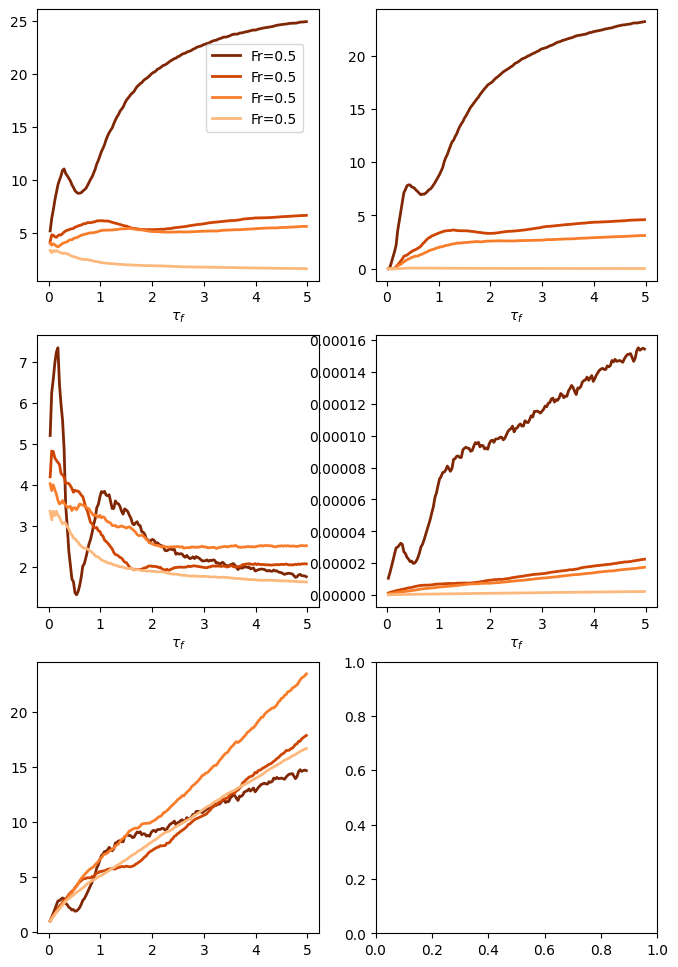

In [ ]:
dt = 0.03
times = dt * np.arange(len(influx_series_m))
St0 = [4,1,0.75,0.25]
Fr = [0.5,0.5, 0.5, 0.5]
N0 = 15**3
alpha = 0.4
K = 1e5

blues = cm.get_cmap("Oranges", 10)
fig, ax = plt.subplots(3,2, figsize=(8, 12))

influx_volume_h = np.cumsum((St0[0]**1.5) * (np.array(influx_series_h[1:])))
influx_volume_m = np.cumsum((St0[1]**1.5) * (np.array(influx_series_m[1:])))
influx_volume_l = np.cumsum((St0[2]**1.5) * (np.array(influx_series_l[1:])))
influx_volume_ll = np.cumsum((St0[3]**1.5) * (np.array(influx_series_ll[1:])))

net_ent_vol_h = np.cumsum(np.array(entrained_volume_h) - np.array(detrained_volume_h))
net_ent_vol_m = np.cumsum(np.array(entrained_volume_m) - np.array(detrained_volume_m))
net_ent_vol_l = np.cumsum(np.array(entrained_volume_l) - np.array(detrained_volume_l))
net_ent_vol_ll = np.cumsum(np.array(entrained_volume_ll) - np.array(detrained_volume_ll))

# alpha = 0.4
R_hat = 1.4773
W = 0.5486

# # alpha = 0.8
# R_hat = 1.6714
# W = 0.4428

# # alpha = 1.4
# R_hat = 2
# W = 0.2667

denom_h = np.pi * (R_hat**2) * (2*W) * (N0 * (St0[0]**1.5) / 64) * times[1:]
denom_m = np.pi * (R_hat**2) * (2*W) * (N0 * (St0[1]**1.5) / 64) * times[1:]
denom_l = np.pi * (R_hat**2) * (2*W) * (N0 * (St0[2]**1.5) / 64) * times[1:]
denom_ll = np.pi * (R_hat**2) * (2*W) * (N0 * (St0[3]**1.5) / 64) * times[1:]
core_volume = 2 * (np.pi**2) * (alpha**2) * (1**3) 

# entrainment volume (normalised by influx volume)
ax[0,0].plot(times[1:], np.cumsum(entrained_volume_h)/denom_h, label=f'Fr={Fr[0]}', linewidth=2, color=blues(9))
ax[0,0].plot(times[1:], np.cumsum(entrained_volume_m)/denom_m, label=f'Fr={Fr[1]}', linewidth=2, color=blues(7))
ax[0,0].plot(times[1:], np.cumsum(entrained_volume_l)/denom_l, label=f'Fr={Fr[2]}', linewidth=2, color=blues(5))
ax[0,0].plot(times[1:], np.cumsum(entrained_volume_ll)/denom_ll, label=f'Fr={Fr[3]}', linewidth=2, color=blues(3))
# ax[0,0].set_ylim(0, 0.2)
ax[0,0].set_xlabel(r'$\tau_f$')
# ax[0,0].legend(loc=(0.6, 0.55))

# detrainment volume (normalised by inside volume)
ax[0,1].plot(times[1:], np.cumsum(detrained_volume_h)/denom_h, label=f'St={St0[0]}', linewidth=2, color=blues(9))
ax[0,1].plot(times[1:], np.cumsum(detrained_volume_m)/denom_m, label=f'St={St0[1]}', linewidth=2, color=blues(7))
ax[0,1].plot(times[1:], np.cumsum(detrained_volume_l)/denom_l, label=f'St={St0[2]}', linewidth=2, color=blues(5))
ax[0,1].plot(times[1:], np.cumsum(detrained_volume_ll)/denom_ll, label=f'St={St0[3]}', linewidth=2, color=blues(3))
ax[0,1].set_xlabel(r'$\tau_f$')
ax[0,0].legend(loc=(0.6, 0.55))

# net entrainment volume (normalised by influx volume)
ax[1,0].plot(times[1:], net_ent_vol_h/denom_h, label=f'Fr={Fr[0]}', linewidth=2, color=blues(9))
ax[1,0].plot(times[1:], net_ent_vol_m/denom_m, label=f'Fr={Fr[1]}', linewidth=2, color=blues(7))
ax[1,0].plot(times[1:], net_ent_vol_l/denom_l, label=f'Fr={Fr[2]}', linewidth=2, color=blues(5))
ax[1,0].plot(times[1:], net_ent_vol_ll/denom_ll, label=f'Fr={Fr[3]}', linewidth=2, color=blues(3))
ax[1,0].set_xlabel(r'$\tau_f$')
# ax[1,0].set_ylim(0, 0.2)

# inside volume increaser (normalised by initial volume)
ax[1,1].plot(times[1:], np.array(inside_vol_h)*(np.pi/(6*K**1.5))/core_volume, label=f'Fr={Fr[0]}', linewidth=2, color=blues(9))
ax[1,1].plot(times[1:], np.array(inside_vol_m)*(np.pi/(6*K**1.5))/core_volume, label=f'Fr={Fr[1]}', linewidth=2, color=blues(7))
ax[1,1].plot(times[1:], np.array(inside_vol_l)*(np.pi/(6*K**1.5))/core_volume, label=f'Fr={Fr[2]}', linewidth=2, color=blues(5))
ax[1,1].plot(times[1:], np.array(inside_vol_ll)*(np.pi/(6*K**1.5))/core_volume, label=f'Fr={Fr[3]}', linewidth=2, color=blues(3))
ax[1,1].set_xlabel(r'$\tau_f$')

# inside concentration increaser (normalised by initial concentration)
ax[2,0].plot(times[1:], np.array(inside_vol_h)/inside_vol_h[0], label=f'Fr={Fr[0]}', linewidth=2, color=blues(9))
ax[2,0].plot(times[1:], np.array(inside_vol_m)/inside_vol_m[0], label=f'Fr={Fr[1]}', linewidth=2, color=blues(7))
ax[2,0].plot(times[1:], np.array(inside_vol_l)/inside_vol_l[0], label=f'Fr={Fr[2]}', linewidth=2, color=blues(5))
ax[2,0].plot(times[1:], np.array(inside_vol_ll)/inside_vol_ll[0], label=f'Fr={Fr[3]}', linewidth=2, color=blues(3))

print((net_ent_vol_h/denom_h)[-1])

In [5]:
for files in [files_h, files_m, files_l]:

    entrained_num = []
    detrained_num = []
    entrained_volume = []
    detrained_volume = []
    inside_number = []

    for f, file in enumerate(files):

        if f == 0:

            file = files[0]
            data = np.load(os.path.join(directory, file))
            inside_previous, outside_previous = find_inside_points(data)
            inside_number.append(len(inside_previous))

            continue


        data_now = np.load(os.path.join(directory, files[f]))
        inside_now, outside_now = find_inside_points(data_now)

        entrained_bubbles = np.intersect1d(outside_previous[:, 0], inside_now[:, 0])
        entrained_stokes = inside_now[np.isin(inside_now[:, 0], entrained_bubbles), -1]

        detrained_bubbles = np.intersect1d(outside_now[:, 0], inside_previous[:, 0])
        detrained_stokes = outside_now[np.isin(outside_now[:, 0], detrained_bubbles), -1]

        entrained_num.append(len(entrained_stokes))
        detrained_num.append(len(detrained_stokes))
        entrained_volume.append(np.sum(entrained_stokes**1.5))
        detrained_volume.append(np.sum(detrained_stokes**1.5))

        outside_previous = outside_now
        inside_previous = inside_now

        inside_number.append(len(inside_now))

    with open(os.path.join(directory, 'influx_series.pkl'), 'rb') as f:
        influx_series = pickle.load(f)



In [7]:
dt = 0.03
times = dt * np.arange(len(influx_series))
St0 = 1
N0 = 15**3

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0,0].plot(times[1:], entrained_num, label='entrained', linewidth=1)
ax[0,0].plot(times[1:], detrained_num, label='detrained', linewidth=1)
ax[0,0].plot(times, influx_series, label='influx', linewidth=1)
ax[0,0].legend()
# ax[0,0].set_title('entrained and detrained particles of case 7')

ax[0,1].plot(times[1:], np.cumsum(entrained_num), label='entrained number', linewidth=1)
ax[0,1].plot(times[1:], np.cumsum(detrained_num), label='detrained number', linewidth=1)
ax[0,1].plot(times, np.cumsum(influx_series), label='influx number', linewidth=1)
# ax[0,1].plot(times, np.cumsum(inside_number), label='inside', linewidth=1,linestyle='--')
ax[0,1].plot(times[1:], np.cumsum(inside_number)[1:] - np.cumsum(inside_number)[:-1], label='rate_increase', linewidth=1)
# ax[0,1].plot(times[1:], np.array(entrained_num) - np.array(detrained_num), label='entrained - detrained', linewidth=1)
ax[0,1].legend()
# ax[0,1].set_title('cumulative entrained and detrained particles of case 7')

ax[1,0].plot(times[1:], np.cumsum(entrained_volume), label='entrained volume', linewidth=1)
ax[1,0].plot(times[1:], np.cumsum(detrained_volume), label='detrained volume', linewidth=1)
ax[1,0].plot(times[1:], np.cumsum(np.array(entrained_volume) - np.array(detrained_volume)), label='entrained - detrained', linewidth=1)
ax[1,0].plot(times, np.cumsum((St0**1.5) * (np.array(influx_series))), label='influx volume', linewidth=1)
ax[1,0].legend()


NameError: name 'influx_series' is not defined

24.359113602190465


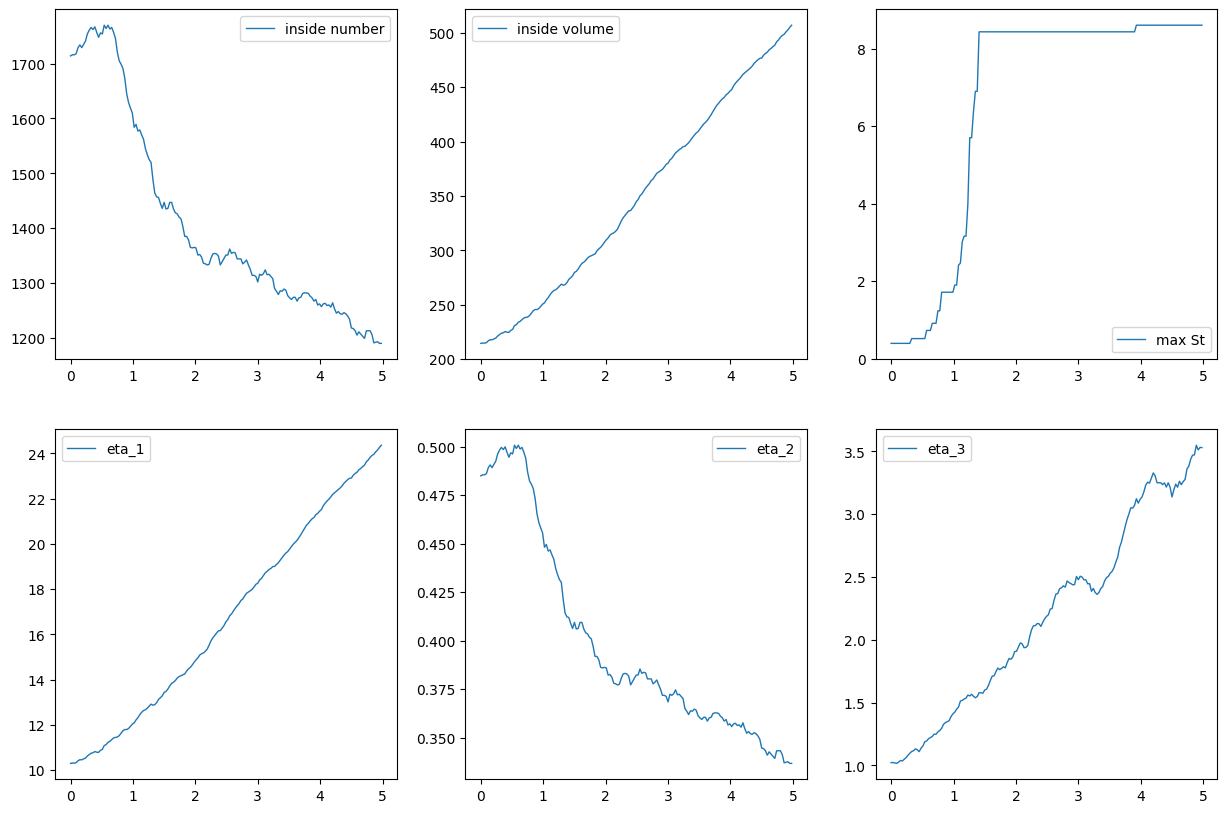

In [112]:
R0 = 1
dt = 0.03
K = 1e7
N_inf = 15**3
St_inf = 0.25
alpha = 0.4

perc = []
inside_numbers = []
inside_volumes = []
volume_perc = []
max_st = []
vol_density = []
possible_st = []
eta_1_list = [] 
eta_2_list = []
eta_3_list = []

directory = '../influx_random_sims_3D_duo/N_realisation_4_bounce/'

files = sorted([file for file in os.listdir(directory) if file.endswith('.npy')], key=lambda x: int(re.search(r'\d+', x).group()))

for f, file in enumerate(files):
    data = np.load(os.path.join(directory, file))
    inside, outside = find_inside_points(data)
    inside_stokes = inside[:, -1]
    outside_stokes = outside[:, -1]
    inside_volumes.append(np.sum(inside_stokes**1.5))
    inside_numbers.append(len(inside_stokes))
    eta_1 = (32/((np.pi)**2 * (alpha)**2)) * (np.sum(inside_stokes**1.5) / (N_inf * (St_inf**1.5)))
    # eta_1 = (48/np.pi) * (np.sum(inside_stokes**1.5) /( N_inf* (St_inf**1.5)))
    eta_2 = (3/np.pi) * (len(inside_stokes) / N_inf)
    eta_3 = np.sum(inside_stokes**1.5) / np.sum(outside_stokes**1.5)
    eta_1_list.append(eta_1)
    eta_2_list.append(eta_2)
    eta_3_list.append(eta_3)
    max_st.append(np.max(inside_stokes) if len(inside_stokes) > 0 else None)

time_here = dt*np.arange(len(files))
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax[0,0].plot(time_here, inside_numbers, label='inside number', linewidth=1)
ax[0,0].legend()
ax[0,1].plot(time_here, inside_volumes, label='inside volume', linewidth=1)
ax[0,1].legend()
ax[0,2].plot(time_here, max_st, label='max St', linewidth=1)
ax[0,2].legend()

ax[1,0].plot(time_here, eta_1_list, label='eta_1', linewidth=1)
ax[1,0].legend()
ax[1,1].plot(time_here, eta_2_list, label='eta_2', linewidth=1)
ax[1,1].legend()
ax[1,2].plot(time_here, eta_3_list, label='eta_3', linewidth=1)
ax[1,2].legend()

print(eta_1)



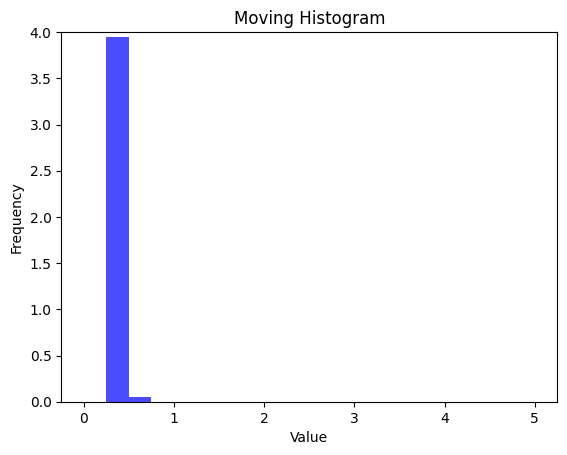

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Create a figure and axis
fig, ax = plt.subplots()
x_data = []

# Set the desired x-axis range
x_min = 0
x_max = 5
ax.set_xlim(x_min, x_max)

# Function to update the histogram
def update(frame):
    # Generate some random data for each frame
    data = np.load(os.path.join(directory, files[frame]))
    inside = data[:, 1] ** 2 + data[:, 2] ** 2 < R0
    stokes = data[inside, -1]
    x_data.append(stokes)
    
    # Update the histogram with the new data
    ax.clear()
    ax.hist(stokes, bins=20, color='blue', alpha=0.7, range=(x_min, x_max), density=True)
    ax.set_ylim(0, 4)
    ax.set_title('Moving Histogram')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

# Create the animation
ani = FuncAnimation(fig, update, frames=range(len(files)), repeat=False)

# Save the animation as a GIF
ani.save('moving_histogram.mp4', writer='ffmpeg', dpi=300)

# plt.show()  # optional, this line can be removed if you don't want to display the animation


[]

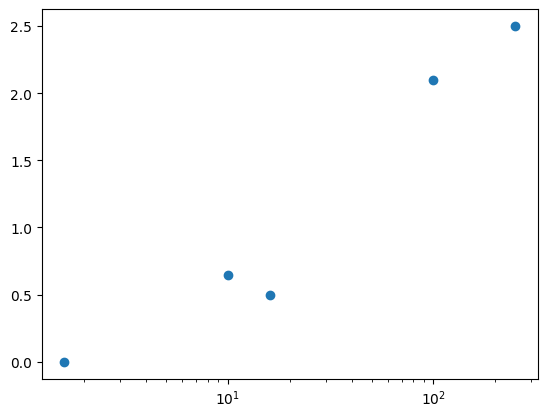

In [29]:
st0 = np.array([0.25, 0.25, 0.01, 2.5, 0.25, 2.5, 2.5, 0.1])
fr = np.array([5, 2, 5, 5, 10, 10, 2, 5])
param = fr**2 / st0
vol_change = np.array([2.1, 0.5, None, 0.65, None, None, 0, 2.5])
type = ['increase', 'decrease', 'no plateau', 'decrease', 'no plateau', 'no plateau', 'decrease', 'increase']
plt.plot(param, vol_change, 'o')
plt.semilogx()

[]

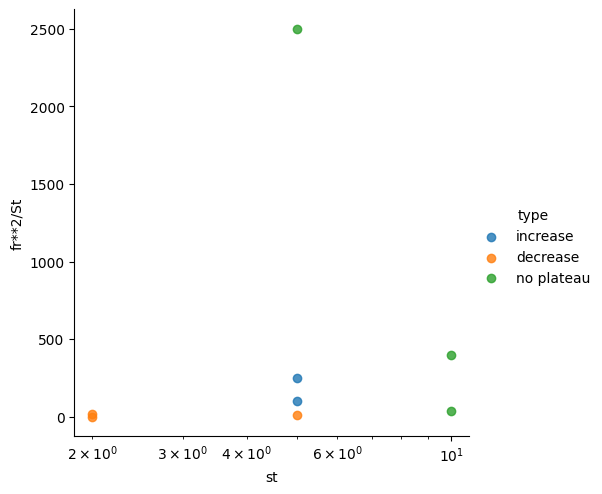

In [34]:
import seaborn as sns
import pandas as pd

# Create a DataFrame
df = pd.DataFrame({
    'st': fr,
    'fr**2/St': param,
    'type': type
})

# Create a scatter plot with a linear fit
sns.lmplot(x='st', y='fr**2/St', hue='type', data=df, fit_reg=False, logx=True)
plt.semilogx()